In [ ]:
## Kết nối Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
folder = '/content/gdrive/My Drive/Colab Notebooks/NLP'

Mounted at /content/gdrive


#THƯ VIỆN CẦN THIẾT PHỤC VỤ CHO BÀI TOÁN



In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install nrclex

In [ ]:
#Thư viện cần thiết:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import tensorflow as tf
# Tắt những cảnh báo
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import state_union
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes as nb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Embedding,  BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from wordcloud import WordCloud
from textblob import TextBlob
from nrclex import NRCLex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# PHẦN 1: TỔNG QUAN DỮ LIỆU

In [ ]:
data=pd.read_csv(folder +'/DisneylandReviews.csv',encoding='ISO-8859-1')
data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


Thông tin cơ bản về file data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


#PHẦN 2: XÂY DỰNG MÔ HÌNH

###Tiền xử lý dữ liệu

In [ ]:
data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
#data trước khi tiền xử lý
df_main_class = data[["Review_Text","Rating"]]
df_main_class

,Review_Text,Rating
0,If you've ever been to Disneyland anywhere you...,4
1,Its been a while since d last time we visit HK...,4
2,Thanks God it wasn t too hot or too humid wh...,4
3,HK Disneyland is a great compact park. Unfortu...,4
4,"the location is not in the city, took around 1...",4
...,...,...
42651,i went to disneyland paris in july 03 and thou...,5
42652,2 adults and 1 child of 11 visited Disneyland ...,5
42653,My eleven year old daughter and myself went to...,5
42654,"This hotel, part of the Disneyland Paris compl...",4


#####Tiền xử lý dữ liệu

Gắn nhãn cho cột Rating

In [ ]:
rating = data["Rating"]
def label_func(rating):
    if rating >=4:
        return "Positive"
    elif rating == 3:
            return "Neutral"
    else:
        return "Negative"

data["Sentiment"] = data["Rating"].apply(lambda x: label_func(x))

In [ ]:
#Tạo hàm tiền xử lý dữ liệu
stop_words = set(stopwords.words('english'))

def clean_reviews(text):
    # Xóa html
    regex = re.compile('<.*?>')
    text = re.sub(regex, '', text)

    # Xóa những ký tự đặc biệt
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern, '', text)

    # Xóa chữ số
    pattern = re.compile('\d+')
    text = re.sub(pattern, '', text)

    # Chuyển đổi text sang chữ thường
    text = text.lower()

    # Tokenization of words
    text = word_tokenize(text)

    # Lemmatization of words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    # Stop words removal
    text = [word for word in text if word not in stop_words]

    # Nối các từ tạo thành một chuỗi
    text = ' '.join(text)

    return text
data['Review_Text'] = data['Review_Text'].apply(clean_reviews)

In [ ]:
#data sau khi tiền xử lý
df_main_class = data[["Review_Text","Sentiment"]]
df_main_class

,Review_Text,Sentiment
0,youve ever disneyland anywhere youll find disn...,Positive
1,since last time visit hk disneyland yet time s...,Positive
2,thanks god hot humid wa visiting park otherwis...,Positive
3,hk disneyland great compact park unfortunately...,Positive
4,location city took around hour kowlon kid like...,Positive
...,...,...
42651,went disneyland paris july thought wa brillian...,Positive
42652,adult child visited disneyland paris beginning...,Positive
42653,eleven year old daughter went visit son london...,Positive
42654,hotel part disneyland paris complex wonderful ...,Positive


###Sentimental Analysis

####Word Cloud

In [ ]:
all_words = ' '.join(word for word in data['Review_Text'])

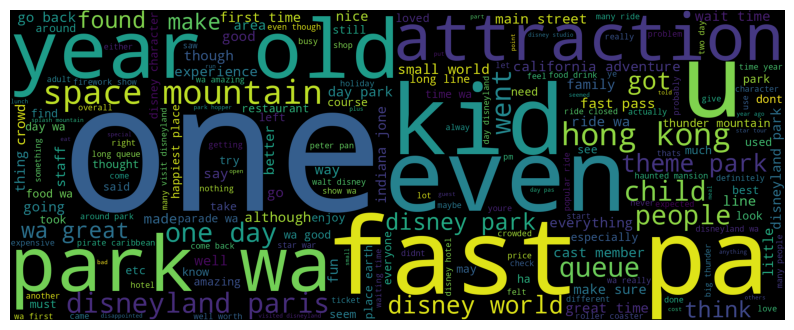

In [ ]:
wordcloud = WordCloud(
    width = 2000,
    height = 800,
    background_color = 'black').generate(all_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

####Generate n-grams unsing Textblob.

In [ ]:
# tính khách quan trong bài Reviews
polarity = []

for sentence in data["Review_Text"]:
    polarity.append(TextBlob(sentence).polarity)

In [ ]:
# Tính chủ quan trong bài Reviews
subjectivity = []

for sentence in data["Review_Text"]:
    subjectivity.append(TextBlob(sentence).subjectivity)

In [ ]:
data["textblob_polarity"], data["textblob_subjectivity"] = polarity, subjectivity

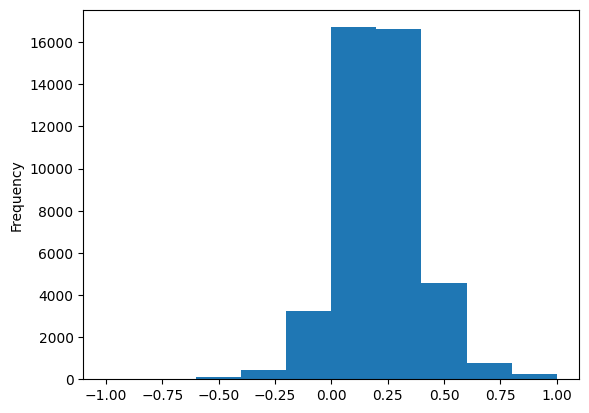

In [ ]:
#Biểu đồ thể hiện tần số tính khách quan
data["textblob_polarity"].plot.hist();

<Axes: ylabel='Frequency'>

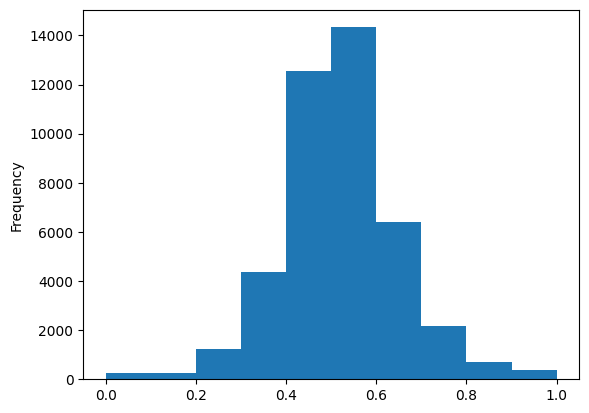

In [ ]:
#Biểu đồ thể hiện tần số tính chủ quan
data["textblob_subjectivity"].plot.hist()

In [ ]:
#Phân loại càm xúc dựa trên chỉ số polarity
data['tb_Sentiment_Type'] = ''
data.loc[data["textblob_polarity"]>0,'tb_Sentiment_Type']='POSITIVE'
data.loc[data["textblob_polarity"]==0,'tb_Sentiment_Type']='NEUTRAL'
data.loc[data["textblob_polarity"]<0,'tb_Sentiment_Type']='NEGATIVE'

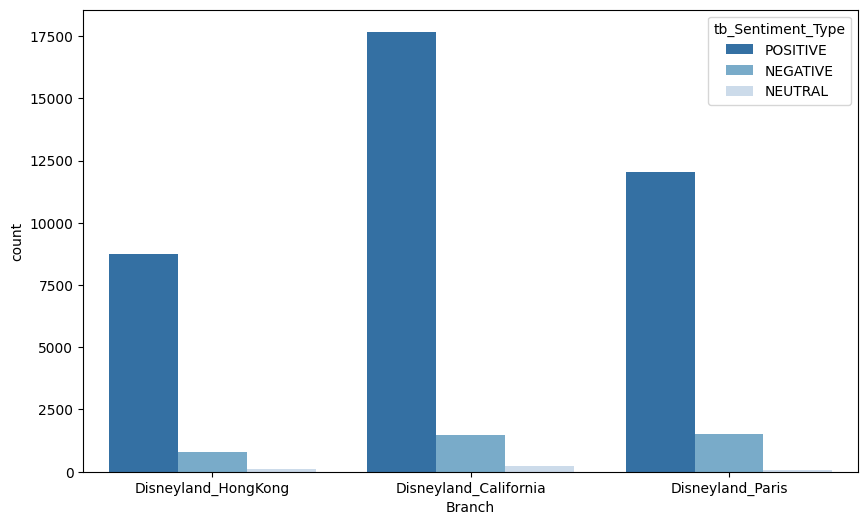

In [ ]:
# oại cảm xúc có trong từng địa điểm
plt.figure(figsize=(10,6))
sns.countplot(data=data,x='Branch',hue='tb_Sentiment_Type',palette='Blues_r');

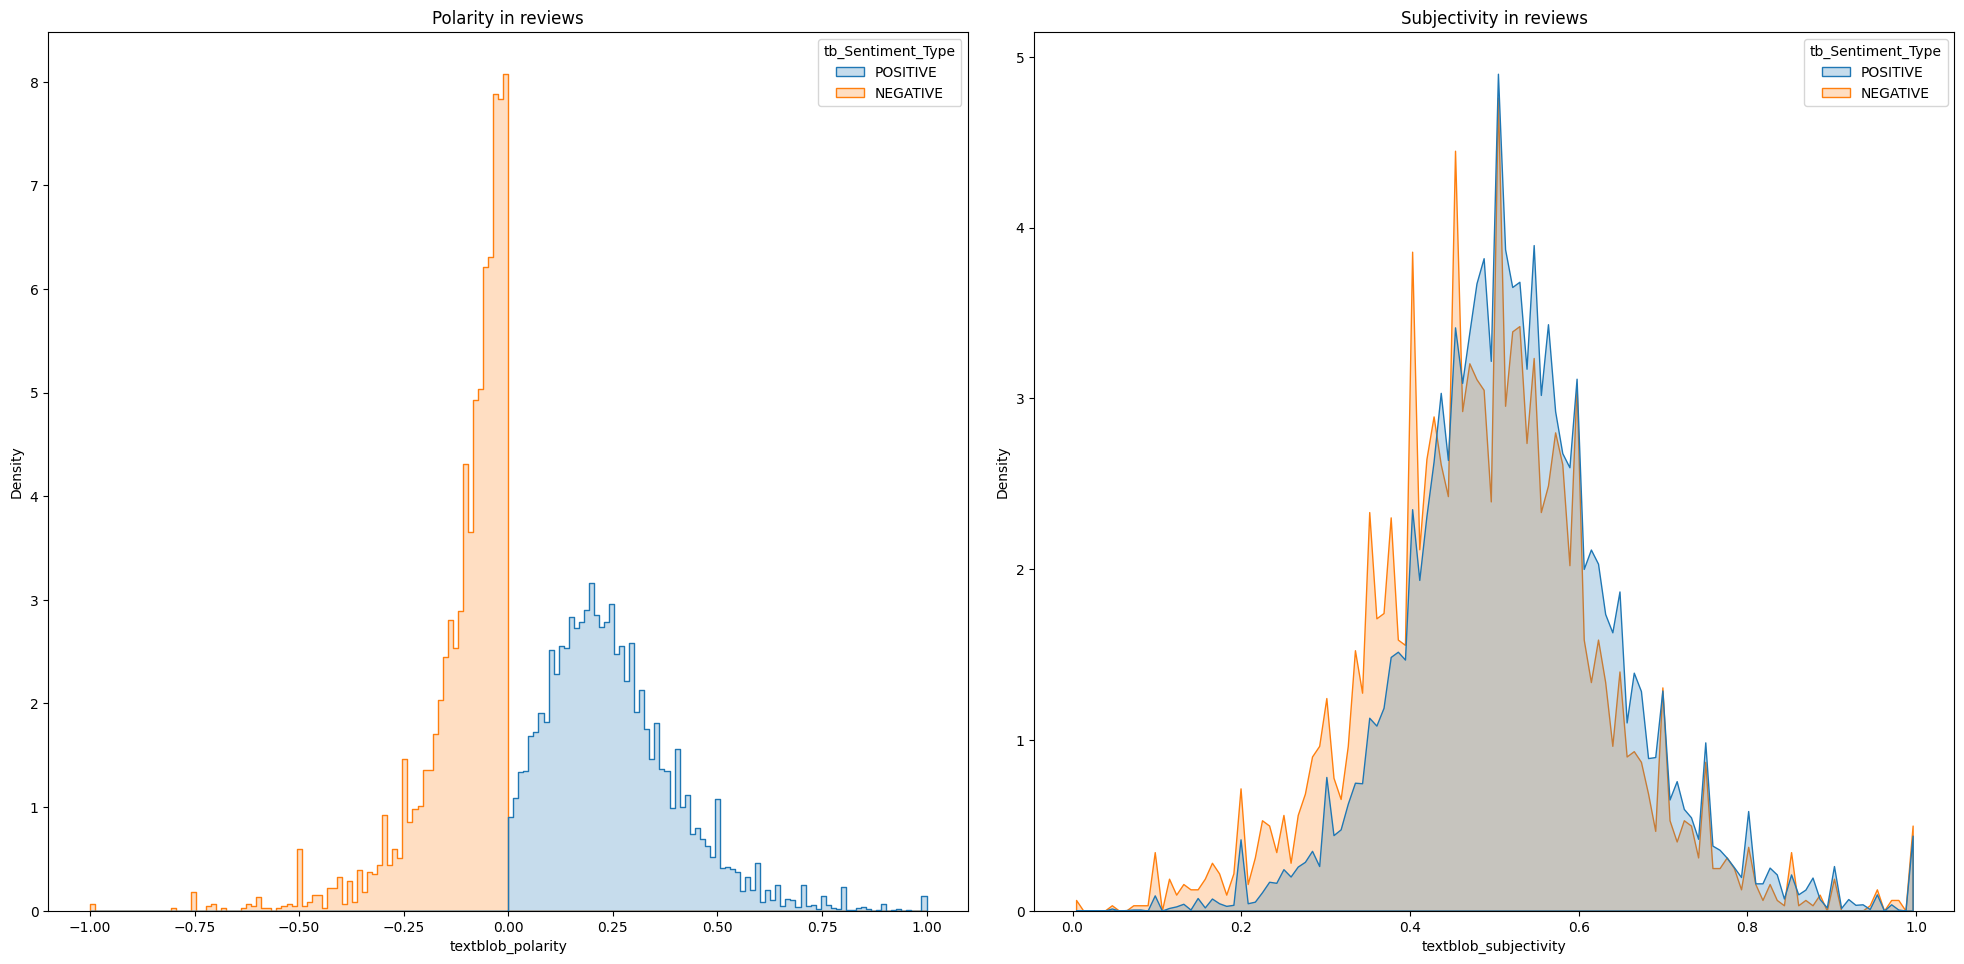

In [ ]:
#Biểu đồ Figure về 2 mức độ polarity và subjectivity:
data1 = data[data.tb_Sentiment_Type != 'NEUTRAL']
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
sns.histplot(data1, x="textblob_polarity", hue="tb_Sentiment_Type", element="step",
             stat="density", common_norm=False, ax=ax1).set(title='Polarity in reviews')
sns.histplot(data1, x="textblob_subjectivity", hue="tb_Sentiment_Type", element="poly",
             stat="density", common_norm=False,ax=ax2).set(title='Subjectivity in reviews')
fig.tight_layout(pad=2.0)

####Vader

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
vs = []
for sentence in data["Review_Text"]:
    vs.append(analyzer.polarity_scores(sentence))

In [ ]:
data["vs_score"] = vs

In [ ]:
#Phân loại cảm xúc dựa trên chủ số vs_score
data['compound'] = data['vs_score'].apply(lambda score_dict: score_dict['compound'])
data['vs_sentiment_type']=''
data.loc[data.compound>0,'vs_sentiment_type']='POSITIVE'
data.loc[data.compound==0,'vs_sentiment_type']='NEUTRAL'
data.loc[data.compound<0,'vs_sentiment_type']='NEGATIVE'

<Axes: xlabel='Branch', ylabel='count'>

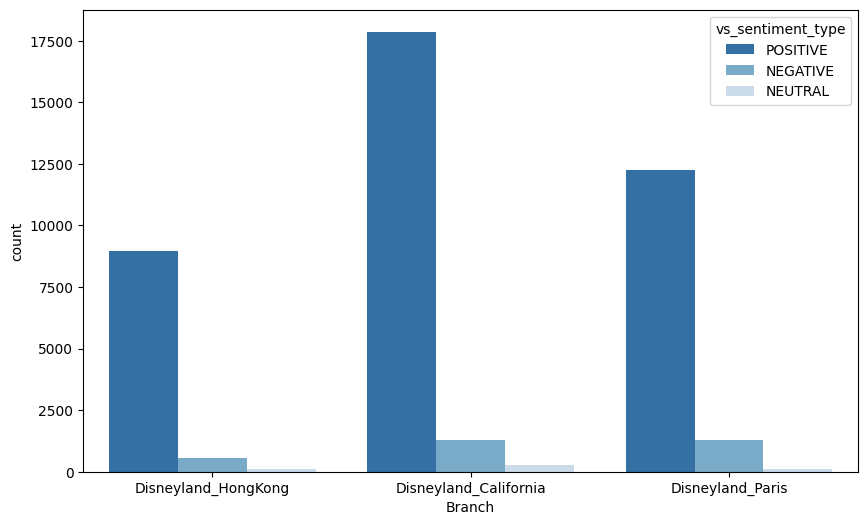

In [ ]:
# Cảm xúc có trong từng địa điểm
plt.figure(figsize=(10,6))
sns.countplot(data=data,x='Branch',hue='vs_sentiment_type',palette='Blues_r')

####NLTK


In [ ]:
stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
nltk_score = []

for review in data["Review_Text"]:
    nltk_score.append(analyzer.polarity_scores(review))

In [ ]:
data["nltk_score"] = nltk_score

In [ ]:

data['nltk_compound'] = data['nltk_score'].apply(lambda score_dict: score_dict['compound'])
data['nltk_sentiment_type']=''
data.loc[data.nltk_compound>0,'nltk_sentiment_type']='POSITIVE'
data.loc[data.nltk_compound==0,'nltk_sentiment_type']='NEUTRAL'
data.loc[data.nltk_compound<0,'nltk_sentiment_type']='NEGATIVE'

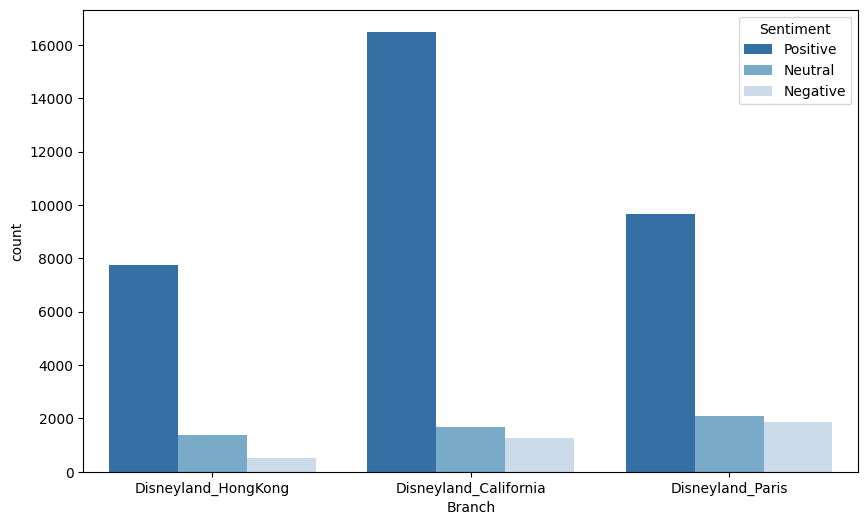

In [ ]:
# Sentiment type by branch
plt.figure(figsize=(10,6))
sns.countplot(data=data,x='Branch',hue='Sentiment',palette='Blues_r');

####Emotion analysis

In [ ]:
emotion = []
for i in range(len(data)):
    emotions = NRCLex(data['Review_Text'][i])
    emotion.append(emotions.top_emotions[0][0])
data['emotion'] = emotion

In [ ]:
data['emotion'].value_counts()

positive        29814
anticipation     5849
trust            2820
negative         2083
fear             1001
surprise          677
anger             363
sadness            32
joy                13
disgust             4
Name: emotion, dtype: int64

In [ ]:
def emotionbranch(branch):
    plt.figure(figsize=(10,5))

    data_ = data[data["Branch"]== branch]

    graph = sns.countplot(y="emotion", data=data_, palette="Set2");
    graph.set(xlabel='Frequency', ylabel='Emotion', title = 'Emotion from reviews ')


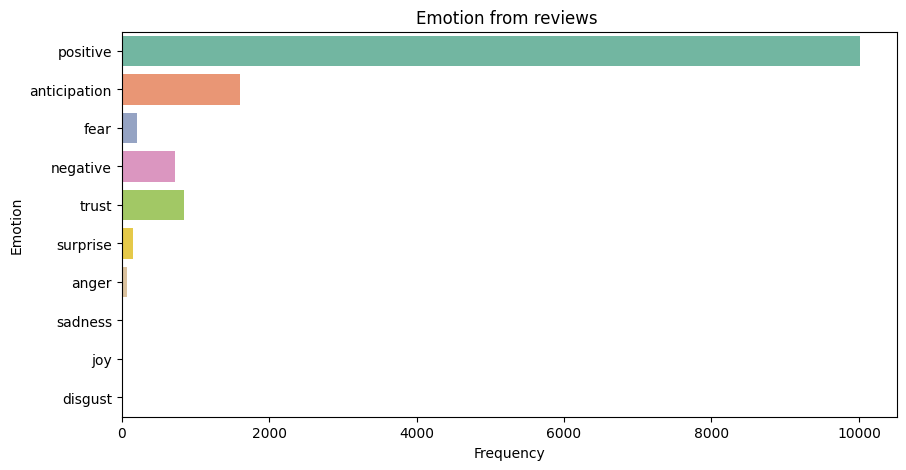

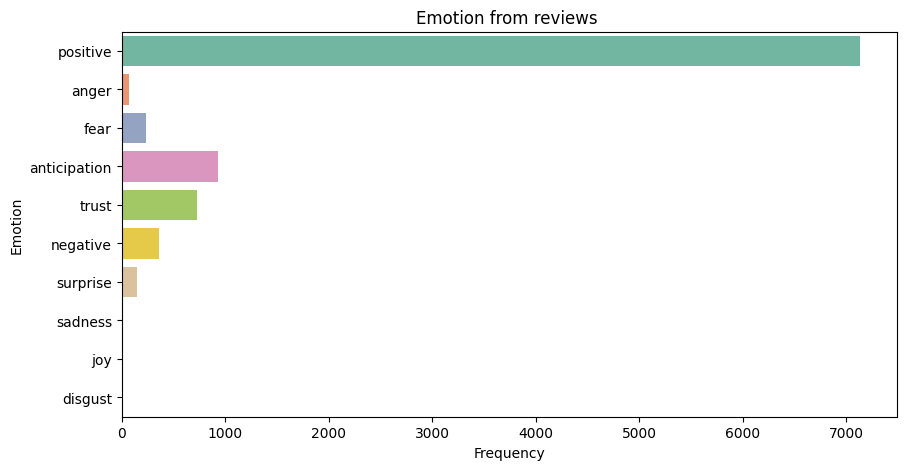

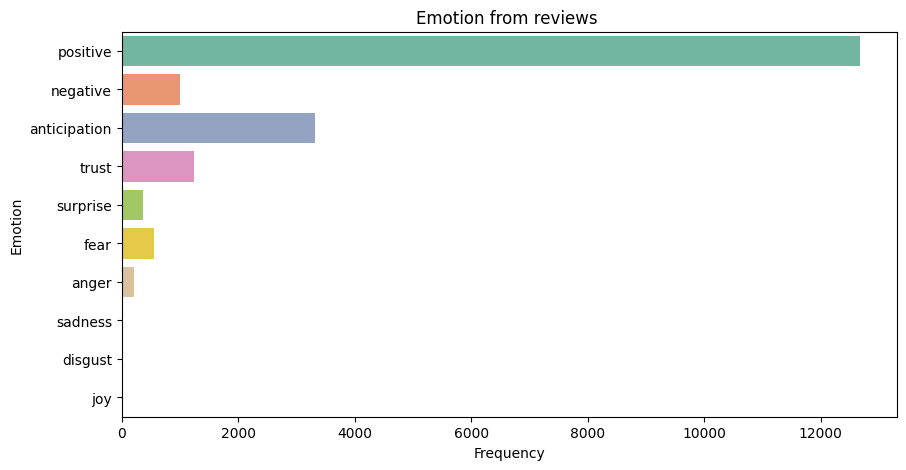

In [ ]:
for branch in ['Disneyland_Paris', 'Disneyland_HongKong', 'Disneyland_California']:
   emotionbranch(branch)

#### Tạo tập dữ liệu kiểm thử và kiểm tra

In [ ]:
X = df_main_class['Review_Text']
y = df_main_class['Sentiment']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỷ lệ 80-20
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

print('Tập Train (80%): ', train_x.shape)
print('Tập Test (20%: ', test_x.shape)

Tập Train (80%):  (34124,)
Tập Test (20%:  (8532,)


###Xây dựng mô hình

##### Naive Bayes Model:


In [ ]:
#Trích chọn đặc trưng theo phương pháp TF_IDF
vector =TfidfVectorizer(analyzer ='word',
                        max_features=35000,
                        stop_words = 'english')
vector.fit(df_main_class['Review_Text'])
xtrain_tfidf = vector.transform(train_x)
xtest_tfidf = vector.transform(test_x)
print('Kết quả vector hóa tập Train sang dạng số:')
print(xtrain_tfidf.data)
print(xtrain_tfidf.shape)
print('Kết quả vector hóa tập Test sang dạng số:')
print(xtest_tfidf.data)
print(xtest_tfidf.shape)

Kết quả vector hóa tập Train sang dạng số:
[0.10443389 0.06894211 0.07245709 ... 0.24082332 0.44093295 0.30857837]
(34124, 35000)
Kết quả vector hóa tập Test sang dạng số:
[0.06356125 0.29141832 0.12852096 ... 0.08389852 0.14622652 0.11414897]
(8532, 35000)


In [ ]:
# Sử dụng GridSearchCV để tìm alpha tốt nhất
MultiNB = nb.MultinomialNB()
alphas = {'alpha': [0.1, 0.25, 0.5, 0.75, 1.0]}
grid = GridSearchCV(estimator=MultiNB, param_grid=alphas, cv=5, scoring='accuracy')
grid.fit(xtrain_tfidf, train_y)
best_alpha = grid.best_params_['alpha']
print("Alpha tốt nhất:", best_alpha )

Alpha tốt nhất: 0.1


In [ ]:
#Sử dụng mô hình Naive Bayes với TF-IDF
#Sử dụng thuật toán MultinomialNB
MultiNB = nb.MultinomialNB(alpha=best_alpha, fit_prior=True)
MultiNB.fit(xtrain_tfidf, train_y)


MultinomialNB(alpha=0.1)

In [ ]:
# Huấn luyện mô hình với tập Train
MultiNB.fit(xtrain_tfidf, train_y)
train_score = MultiNB.score(xtrain_tfidf, train_y)
print(f'Độ chính xác của mô hình trên tập Train: {round(train_score*100,2)}%')

# Tính thời gian huấn luyện trên tập Train
start_time_train = time.time()
MultiNB.fit(xtrain_tfidf, train_y)
end_time_train = time.time()
train_time = end_time_train - start_time_train
print(f'Thời gian huấn luyện trên tập Train: {train_time:.4f} giây')

#Sử dụng mô hình huấn luyện dự đoán trên tập Test
y_pred = MultiNB.predict(xtest_tfidf)
#Đánh giá mô hình trên tập Test
print('classification_report: \n', classification_report(test_y, y_pred))
# Tính thời gian dự đoán trên tập Test
start_time_test = time.time()
y_pred = MultiNB.predict(xtest_tfidf)
end_time_test = time.time()
test_time = end_time_test - start_time_test
print(f'Thời gian dự đoán trên tập Test: {test_time:.4f} giây')

Độ chính xác của mô hình trên tập Train: 86.27%
Thời gian huấn luyện trên tập Train: 0.1009 giây
classification_report: 
               precision    recall  f1-score   support

    Negative       0.68      0.27      0.39       725
     Neutral       0.37      0.05      0.09      1022
    Positive       0.83      0.99      0.90      6785

    accuracy                           0.82      8532
   macro avg       0.63      0.44      0.46      8532
weighted avg       0.76      0.82      0.76      8532

Thời gian dự đoán trên tập Test: 0.0037 giây


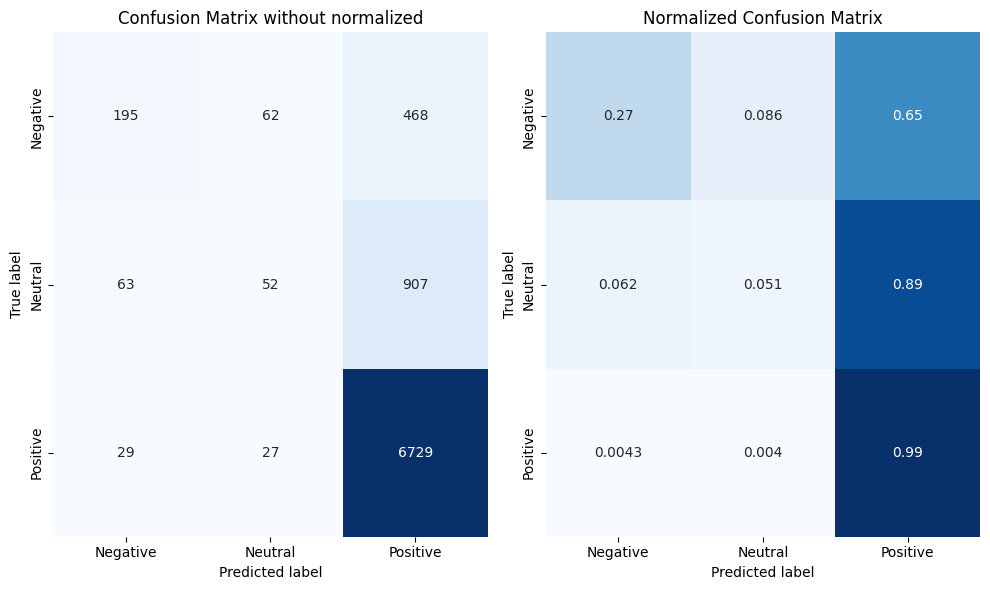

In [ ]:
# Tính toán Confusion Matrix
conf_matrix = confusion_matrix(test_y, y_pred)

# Tính toán Confusion Matrix chuẩn hóa
norm_conf_matrix = confusion_matrix(test_y, y_pred, normalize='true')

# Lấy danh sách nhãn duy nhất từ test_y và sắp xếp chúng
labels = sorted(list(set(test_y)))

# Tạo figure và axes
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # 1 hàng, 2 cột cho hai biểu đồ

# Biểu đồ Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axs[0])
axs[0].set_title("Confusion Matrix without normalized")
axs[0].set_xlabel("Predicted label")
axs[0].set_ylabel("True label")
axs[0].set_xticklabels(labels)
axs[0].set_yticklabels(labels)

# Biểu đồ Confusion Matrix chuẩn hóa
sns.heatmap(norm_conf_matrix, annot=True, cmap="Blues", cbar=False, ax=axs[1])
axs[1].set_title("Normalized Confusion Matrix")
axs[1].set_xlabel("Predicted label")
axs[1].set_ylabel("True label")
axs[1].set_xticklabels(labels)
axs[1].set_yticklabels(labels)

plt.tight_layout()
plt.show()


In [ ]:
# Khởi tạo mô hình Decision Tree với entropy làm tiêu chí cắt nhánh
decision_tree_entropy = DecisionTreeClassifier(criterion='entropy')
decision_tree_entropy.fit(xtrain_tfidf, train_y)
# Đánh giá mô hình trên tập Test
y_pred = decision_tree_entropy.predict(xtest_tfidf)
print('classification_report: \n', classification_report(test_y, y_pred))
# Tính thời gian dự đoán trên tập Test
start_time_test = time.time()
y_pred = decision_tree_entropy.predict(xtest_tfidf)
end_time_test = time.time()
test_time = end_time_test - start_time_test
print(f'Thời gian dự đoán trên tập Test: {test_time:.4f} giây')


classification_report: 
               precision    recall  f1-score   support

    Negative       0.33      0.32      0.32       725
     Neutral       0.20      0.19      0.20      1022
    Positive       0.86      0.87      0.86      6785

    accuracy                           0.74      8532
   macro avg       0.46      0.46      0.46      8532
weighted avg       0.73      0.74      0.74      8532

Thời gian dự đoán trên tập Test: 0.0088 giây


BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Tạo một CountVectorizer
vectorizer = CountVectorizer(analyzer='word', max_features=20000, stop_words='english')

# Khớp dữ liệu văn bản vào vectorizer để tạo BoW
vectorizer.fit(df_main_class['Review_Text'])

# Chuyển đổi dữ liệu huấn luyện và kiểm tra thành dạng ma trận BoW
xtrain_bow = vectorizer.transform(train_x)
xtest_bow = vectorizer.transform(test_x)

# In ra thông tin về ma trận BoW
print('Kết quả vector hóa tập Train sang dạng số:')
print(xtrain_bow.toarray())
print(xtrain_bow.shape)
print('Kết quả vector hóa tập Test sang dạng số:')
print(xtest_bow.toarray())
print(xtest_bow.shape)


Kết quả vector hóa tập Train sang dạng số:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(34124, 20000)
Kết quả vector hóa tập Test sang dạng số:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(8532, 20000)


In [ ]:
#Sử dụng mô hình Naive Bayes với BoW
from sklearn import naive_bayes as nb

#Sử dụng thuật toán MultinomialNB
MultiNB = nb.MultinomialNB(alpha = 0.1, fit_prior=True)
MultiNB.fit(xtrain_bow, train_y)


MultinomialNB(alpha=0.1)

In [ ]:
from sklearn.metrics import accuracy_score
# Huấn luyện mô hình với tập Train
MultiNB.fit(xtrain_bow, train_y)

#Sử dụng mô hình huấn luyện dự đoán trên tập Test
y_pred = MultiNB.predict(xtest_bow)
#Đánh giá mô hình trên tập Test
print('classification_report: \n', classification_report(test_y, y_pred))
# Tính thời gian dự đoán trên tập Test
start_time_test = time.time()
y_pred = MultiNB.predict(xtest_bow)
end_time_test = time.time()
test_time = end_time_test - start_time_test
print(f'Thời gian dự đoán trên tập Test: {test_time:.4f} giây')

classification_report: 
               precision    recall  f1-score   support

    Negative       0.53      0.62      0.57       725
     Neutral       0.36      0.33      0.35      1022
    Positive       0.92      0.91      0.92      6785

    accuracy                           0.82      8532
   macro avg       0.60      0.62      0.61      8532
weighted avg       0.82      0.82      0.82      8532

Thời gian dự đoán trên tập Test: 0.0055 giây


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo mô hình Decision Tree với entropy làm tiêu chí cắt nhánh
decision_tree_entropy = DecisionTreeClassifier(criterion='entropy')
decision_tree_entropy.fit(xtrain_bow, train_y)
# Đánh giá mô hình trên tập Test
y_pred = decision_tree_entropy.predict(xtest_bow)
print('classification_report: \n', classification_report(test_y, y_pred))
# Tính thời gian dự đoán trên tập Test
start_time_test = time.time()
y_pred = decision_tree_entropy.predict(xtest_bow)
end_time_test = time.time()
test_time = end_time_test - start_time_test
print(f'Thời gian dự đoán trên tập Test: {test_time:.4f} giây')


classification_report: 
               precision    recall  f1-score   support

    Negative       0.34      0.34      0.34       725
     Neutral       0.22      0.19      0.20      1022
    Positive       0.86      0.87      0.87      6785

    accuracy                           0.75      8532
   macro avg       0.47      0.47      0.47      8532
weighted avg       0.74      0.75      0.74      8532

Thời gian dự đoán trên tập Test: 0.0082 giây


#####MaxentClassifier(Logistic Regression)

In [ ]:
# Define a list of possible values for C
C_values = [0.1, 0.6, 0.7, 0.8, 1.0, 5.0, 10.0]

# Define a list of possible solvers
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create a logistic regression model
logistic_regression = LogisticRegression()

# Create a parameter grid
param_grid = {'C': C_values, 'solver': solvers}

# Perform grid search using cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(xtrain_tfidf, train_y)

# Get the best parameters
best_parameters = grid_search.best_params_
best_C = best_parameters['C']
best_solver = best_parameters['solver']

print("Best C:", best_C)
print("Best solver:", best_solver)

Best C: 1.0
Best solver: lbfgs


In [ ]:
LogReg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)
LogReg.fit(xtrain_tfidf, train_y)

LogisticRegression()

In [ ]:
# Huấn luyện mô hình với tập Train
LogReg.fit(xtrain_tfidf, train_y)
train_score = LogReg.score(xtrain_tfidf, train_y)
print(f'Độ chính xác của mô hình trên tập Train: {round(train_score*100,2)}%')

# Tính thời gian huấn luyện trên tập Train
start_time_train = time.time()
LogReg.fit(xtrain_tfidf, train_y)
end_time_train = time.time()
train_time = end_time_train - start_time_train
print(f'Thời gian huấn luyện trên tập Train: {train_time:.4f} giây')

#Sử dụng mô hình huấn luyện dự đoán trên tập Test
y_pred_tfidf = LogReg.predict(xtest_tfidf)
#Đánh giá mô hình trên tập Test
print('classification_report: \n', classification_report(test_y, y_pred_tfidf))
# Tính thời gian dự đoán trên tập Test
start_time_test = time.time()
y_pred_tfidf = LogReg.predict(xtest_tfidf)
end_time_test = time.time()
test_time = end_time_test - start_time_test
print(f'Thời gian dự đoán trên tập Test: {test_time:.4f} giây')

Độ chính xác của mô hình trên tập Train: 88.41%
Thời gian huấn luyện trên tập Train: 14.0400 giây
classification_report: 
               precision    recall  f1-score   support

    Negative       0.67      0.53      0.59       725
     Neutral       0.49      0.23      0.31      1022
    Positive       0.88      0.98      0.93      6785

    accuracy                           0.85      8532
   macro avg       0.68      0.58      0.61      8532
weighted avg       0.82      0.85      0.83      8532

Thời gian dự đoán trên tập Test: 0.0054 giây


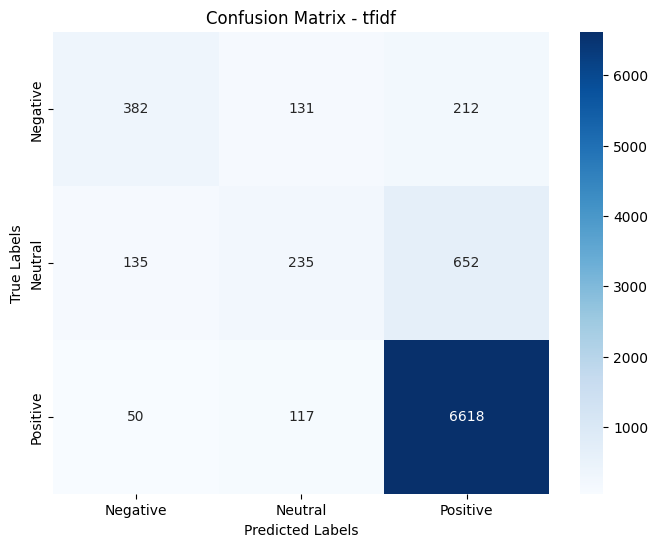

In [ ]:
# Vẽ confusion matrix
conf_matrix_tfidf = confusion_matrix(test_y, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - tfidf')
plt.show()

In [ ]:
LogReg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)
LogReg.fit(xtrain_bow, train_y)

LogisticRegression()

In [ ]:
# Huấn luyện mô hình với tập Train
LogReg.fit(xtrain_bow, train_y)
train_score = LogReg.score(xtrain_bow, train_y)
print(f'Độ chính xác của mô hình trên tập Train: {round(train_score*100,2)}%')

# Tính thời gian huấn luyện trên tập Train
start_time_train = time.time()
LogReg.fit(xtrain_bow, train_y)
end_time_train = time.time()
train_time = end_time_train - start_time_train
print(f'Thời gian huấn luyện trên tập Train: {train_time:.4f} giây')

#Sử dụng mô hình huấn luyện dự đoán trên tập Test
y_pred_bow = LogReg.predict(xtest_bow)
#Đánh giá mô hình trên tập Test
print('classification_report: \n', classification_report(test_y, y_pred_bow))
# Tính thời gian dự đoán trên tập Test
start_time_test = time.time()
y_pred_bow = LogReg.predict(xtest_bow)
end_time_test = time.time()
test_time = end_time_test - start_time_test
print(f'Thời gian dự đoán trên tập Test: {test_time:.4f} giây')

Độ chính xác của mô hình trên tập Train: 93.35%
Thời gian huấn luyện trên tập Train: 10.7780 giây
classification_report: 
               precision    recall  f1-score   support

    Negative       0.57      0.55      0.56       725
     Neutral       0.41      0.30      0.34      1022
    Positive       0.91      0.95      0.92      6785

    accuracy                           0.83      8532
   macro avg       0.63      0.60      0.61      8532
weighted avg       0.82      0.83      0.82      8532

Thời gian dự đoán trên tập Test: 0.0056 giây


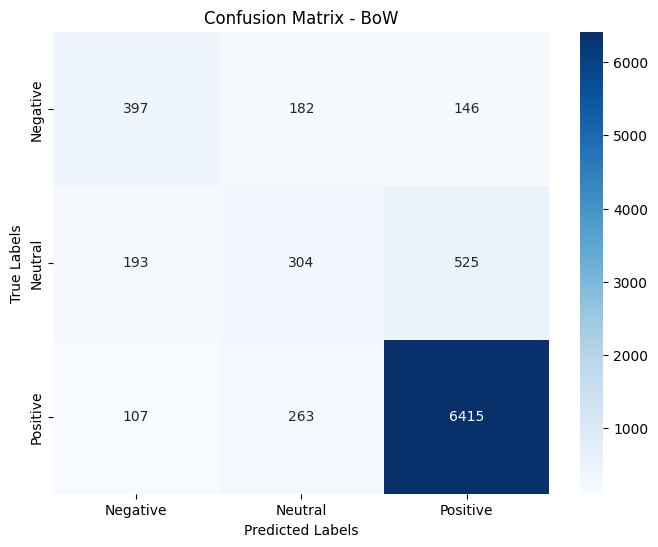

In [ ]:
# Vẽ confusion matrix
conf_matrix_bow = confusion_matrix(test_y, y_pred_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bow, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - BoW')
plt.show()

#####Deep Learning (RNN)


In [ ]:
print(df_main_class.columns)

Index(['Review_Text', 'Sentiment_Negative', 'Sentiment_Neutral',
       'Sentiment_Positive'],
      dtype='object')


In [ ]:
tokenizer = Tokenizer()
# chuyển đổi reviews thành list
reviews_to_list = df_main_class['Review_Text'].tolist()
tokenizer.fit_on_texts(reviews_to_list)
# Tạo chuỗi văn bản
text_sequences = np.array(tokenizer.texts_to_sequences(reviews_to_list))

# one hot encoding
df_main_class = pd.get_dummies(df_main_class, columns = ['Sentiment'])

# setting maximum words
max_words = 500

# X (input) to the model
# using pad_sequences and y (output)
X = pad_sequences(text_sequences, maxlen = max_words)
y = df_main_class[['Sentiment_Negative','Sentiment_Neutral','Sentiment_Positive']]
print(X.shape, y.shape)

(42656, 500) (42656, 3)


In [ ]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
                        max_words,
                        input_length=max_words))

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(Dense(3, activation='softmax'))

# printing model summary
print(rnn.summary())

Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 500)          32304000  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 500, 128)          80512     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 32397059 (123.58 MB)
Trainable params: 32397059 (123.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỷ lệ 80-20
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

print('Tập Train (80%): ', train_x.shape)
print('Tập Test (20%: ', test_x.shape)

Tập Train (80%):  (34124, 500)
Tập Test (20%:  (8532, 500)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Compiling model
rnn.compile(
	loss="categorical_crossentropy",
	optimizer='adam',
	metrics=['accuracy']
)

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Training the model
history = rnn.fit(train_x, train_y,
						batch_size=64,
						epochs=50,
						verbose=1,
						validation_data = (test_x, test_y),
						callbacks=[early_stopping])

print("Simple_RNN Score---> ", rnn.evaluate(test_x, test_y, verbose=1))


Epoch 1/50
534/534 [==============================] - 1060s 2s/step - loss: 0.5050 - accuracy: 0.8108 - val_loss: 0.5340 - val_accuracy: 0.8138
Epoch 2/50
534/534 [==============================] - 1031s 2s/step - loss: 0.3819 - accuracy: 0.8457 - val_loss: 0.4571 - val_accuracy: 0.8312
Epoch 3/50
534/534 [==============================] - 1025s 2s/step - loss: 0.2977 - accuracy: 0.8834 - val_loss: 0.6097 - val_accuracy: 0.8156
Epoch 4/50
534/534 [==============================] - 1032s 2s/step - loss: 0.2129 - accuracy: 0.9167 - val_loss: 0.6134 - val_accuracy: 0.7958
Epoch 5/50
267/267 [==============================] - 42s 158ms/step - loss: 0.4571 - accuracy: 0.8312
Simple_RNN Score--->  [0.45712682604789734, 0.8312236070632935]


Text(0, 0.5, 'Accuracy')

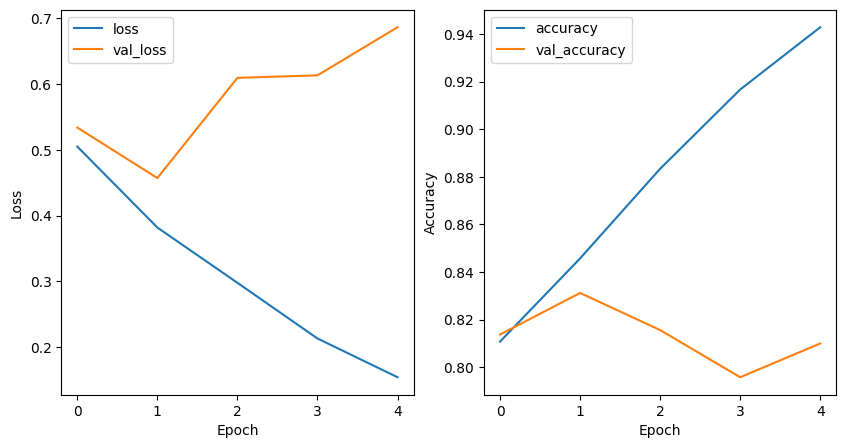

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
		metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


267/267 [==============================] - 43s 159ms/step


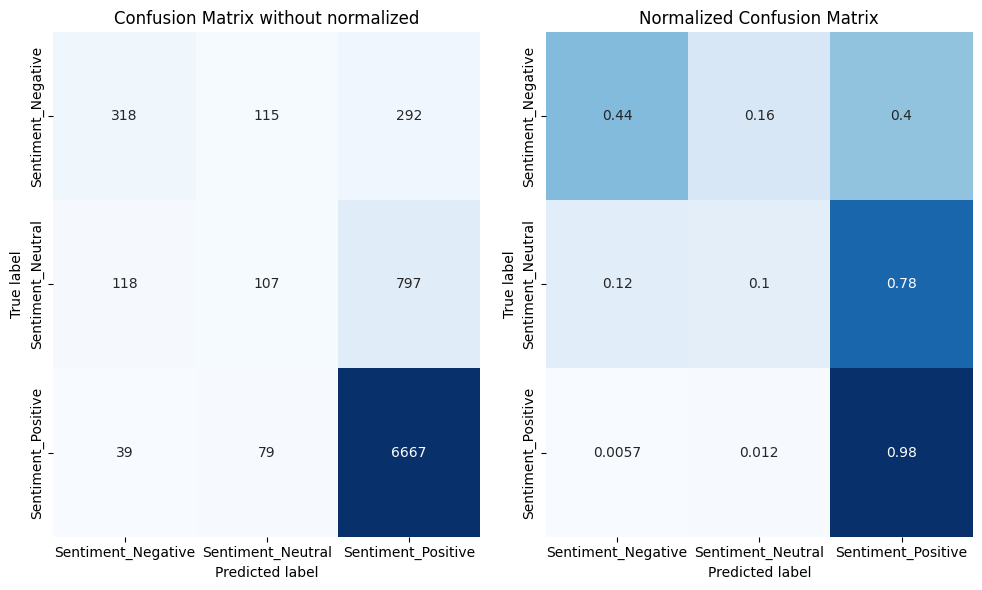

In [ ]:
#confusion matrix
y_true = np.argmax(test_y.values, axis=1)
y_true.shape
y_pred = np.argmax(rnn.predict(test_x), axis=1)
# Tính toán Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Tính toán Confusion Matrix chuẩn hóa
norm_conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
# Lấy danh sách nhãn duy nhất từ test_y và sắp xếp chúng
labels = sorted(list(set(test_y)))

# Tạo figure và axes
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Biểu đồ Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axs[0])
axs[0].set_title("Confusion Matrix without normalized")
axs[0].set_xlabel("Predicted label")
axs[0].set_ylabel("True label")
axs[0].set_xticklabels(labels)
axs[0].set_yticklabels(labels)

# Biểu đồ Confusion Matrix chuẩn hóa
sns.heatmap(norm_conf_matrix, annot=True, cmap="Blues", cbar=False, ax=axs[1])
axs[1].set_title("Normalized Confusion Matrix")
axs[1].set_xlabel("Predicted label")
axs[1].set_ylabel("True label")
axs[1].set_xticklabels(labels)
axs[1].set_yticklabels(labels)

plt.tight_layout()
plt.show()


In [ ]:
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.67      0.44      0.53       725
           1       0.36      0.10      0.16      1022
           2       0.86      0.98      0.92      6785

    accuracy                           0.83      8532
   macro avg       0.63      0.51      0.54      8532
weighted avg       0.78      0.83      0.79      8532

